<a href="https://colab.research.google.com/github/cesarmartinezg-lgtm/Entregas/blob/main/99%20-%20modelo_solucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación de Librerías

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Configuración Kaggle

In [ ]:
# Establecer tus credenciales de Kaggle
os.environ['KAGGLE_USERNAME'] = 'cesarmartinezia'
os.environ['KAGGLE_KEY'] = '3bd3c2a5994356c24295cd5c6d8bba59'

In [ ]:
# Crear manualmente el archivo kaggle.json a partir de esas variables
!mkdir -p ~/.kaggle
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (os.environ['KAGGLE_USERNAME'], os.environ['KAGGLE_KEY']))

In [ ]:
# Ajustar permisos
!chmod 600 /root/.kaggle/kaggle.json

# Descarga de Dataset y cargue




In [ ]:
# Descargar los datos de la competencia
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 508MB/s]


In [ ]:
!unzip udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip

Archive:  udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip
  inflating: submission_example.csv  
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
df_train = pd.read_csv("train.csv")
df_kaggle_test = pd.read_csv("test.csv")
kaggle_ids = df_kaggle_test['ID'].copy()

In [ ]:
# Preprocesamiento
def preprocess(df, is_train=True):
    df = df.copy()
    df = df.drop(columns=[col for col in df.columns if "ID" in col.upper()], errors='ignore')
    y = df.pop('RENDIMIENTO_GLOBAL') if is_train and 'RENDIMIENTO_GLOBAL' in df.columns else None

    for col in df.select_dtypes(include=np.number).columns:
        df[col].fillna(df[col].median(), inplace=True)
    for col in df.select_dtypes(include="object").columns:
        df[col].fillna(df[col].mode()[0] if len(df[col].mode()) > 0 else "DESCONOCIDO", inplace=True)

    return df, y

X_full, y_full = preprocess(df_train, True)
X_kaggle, _ = preprocess(df_kaggle_test, False)

In [ ]:
# Encoding
for col in X_full.select_dtypes(include="object").columns:
    le = LabelEncoder()
    X_full[col] = le.fit_transform(X_full[col].astype(str))

    kaggle_vals = X_kaggle[col].astype(str)
    for val in kaggle_vals.unique():
        if val not in le.classes_:
            le.classes_ = np.append(le.classes_, val)
    X_kaggle[col] = le.transform(kaggle_vals)

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y_full)

# Escalar
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)
X_kaggle_scaled = scaler.transform(X_kaggle)

# DIVISIÓN TRAIN/VAL/TEST (siguiendo 05.03)
print("\n" + "="*70)
print("DIVISIÓN TRAIN/VAL/TEST")
print("="*70)


DIVISIÓN TRAIN/VAL/TEST


In [ ]:
# 1. Separar TEST (30%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_full_scaled, y_encoded, test_size=0.30, random_state=42, stratify=y_encoded
)

print(f"Train+Val: {X_trainval.shape} (70%)")
print(f"Test: {X_test.shape} (30%)")

# PARTE 1: SELECCIÓN DE MODELO (solo 3 modelos para velocidad)
print("\n" + "="*70)
print("SELECCIÓN DE MODELO")
print("="*70)

models = {
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=50, max_depth=15,
                                            random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(n_estimators=50, max_depth=5, learning_rate=0.1,
                                  random_state=42, eval_metric='mlogloss',
                                  use_label_encoder=False, n_jobs=-1)
}

Train+Val: (484750, 18) (70%)
Test: (207750, 18) (30%)

SELECCIÓN DE MODELO


In [ ]:
# CV rápido (3 folds en lugar de 5)
results = {}
best_score = -1
best_model_name = None

for name, model in models.items():
    scores = cross_val_score(model, X_trainval, y_trainval,
                             cv=3, scoring='accuracy', n_jobs=-1)
    mean_score = scores.mean()
    results[name] = mean_score

    print(f"{name:20s} | Val: {mean_score:.4f} (±{scores.std():.4f})")

    if mean_score > best_score:
        best_score = mean_score
        best_model_name = name

print(f"\n→ MODELO SELECCIONADO: {best_model_name}")

Logistic Regression  | Val: 0.3572 (±0.0011)
Random Forest        | Val: 0.3849 (±0.0010)
XGBoost              | Val: 0.3938 (±0.0003)

→ MODELO SELECCIONADO: XGBoost


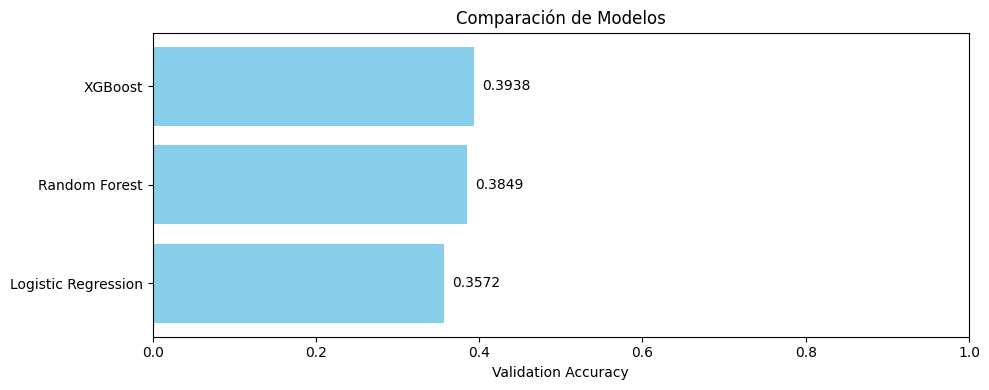

In [ ]:
# Visualización simple
plt.figure(figsize=(10, 4))
names = list(results.keys())
scores = list(results.values())
plt.barh(names, scores, color='skyblue')
plt.xlabel('Validation Accuracy')
plt.title('Comparación de Modelos')
plt.xlim(0, 1)
for i, v in enumerate(scores):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150)
plt.show()



In [ ]:
# PARTE 2: EVALUACIÓN EN TEST
print("\n" + "="*70)
print("EVALUACIÓN EN TEST (REPORTE FINAL)")
print("="*70)

final_model = models[best_model_name]
final_model.fit(X_trainval, y_trainval)

y_test_pred = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_test_pred, target_names=le_target.classes_))

# PARTE 3: PREDICCIÓN KAGGLE
print("\n" + "="*70)
print("PREDICCIÓN PARA KAGGLE")
print("="*70)


EVALUACIÓN EN TEST (REPORTE FINAL)

Test Accuracy: 0.3935

Reporte de Clasificación:
              precision    recall  f1-score   support

        alto       0.46      0.61      0.53     52686
        bajo       0.41      0.53      0.47     51896
  medio-alto       0.30      0.19      0.23     51486
  medio-bajo       0.32      0.24      0.27     51682

    accuracy                           0.39    207750
   macro avg       0.37      0.39      0.37    207750
weighted avg       0.37      0.39      0.37    207750


PREDICCIÓN PARA KAGGLE


In [ ]:

# Entrenar con TODOS los datos
kaggle_model = models[best_model_name]
kaggle_model.fit(X_full_scaled, y_encoded)

y_kaggle_pred = kaggle_model.predict(X_kaggle_scaled)
y_kaggle_labels = le_target.inverse_transform(y_kaggle_pred)

# Submission
submission = pd.DataFrame({'ID': kaggle_ids, 'RENDIMIENTO_GLOBAL': y_kaggle_labels})
submission.to_csv('submission_final_99.csv', index=False)

print(f"\n✓ Submission: submission_final_99.csv")
print("\nDistribución:")
print(submission['RENDIMIENTO_GLOBAL'].value_counts())

# RESUMEN
print("\n" + "="*70)
print("RESUMEN")
print("="*70)
print(f"Modelo: {best_model_name}")
print(f"Val Score: {best_score:.4f}")
print(f"Test Score: {test_accuracy:.4f}")
print("="*70)


✓ Submission: submission_final_99.csv

Distribución:
RENDIMIENTO_GLOBAL
alto          101058
bajo           96357
medio-bajo     53954
medio-alto     45417
Name: count, dtype: int64

RESUMEN
Modelo: XGBoost
Val Score: 0.3938
Test Score: 0.3935
